https://github.com/hongdam/pycon2018-RL_Adventure/blob/master/code/4.prioritized%20dqn.ipynb

In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

## Use CUDA

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

# Prioritized Replay Buffer

In [4]:
class NaivePrioritizeBuffer:
    def __init__(self, capacity, prob_alpha=.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros(capacity, dtype=np.float32)
        
    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0) 
        
        max_prio = self.priorities.max() if self.buffer else 1.
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done)) 
        else:
            self.buffer[self.pos] = state, action, reward, next_state, done
        
        self.priorities[self.pos] = max_prio  # 방금 추가된 애한테는 max를 주는 건가
        self.pos = (self.pos + 1) % self.capacity
        
    def sample(self, batch_size, beta=.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        # 이거 뭐임 ㅅㅂ
        # priorities => probability 로 바꿔주는 거 같음
        probs = prios ** self.prob_alpha
        probs /= probs.sum()
        
        # 굳이 왜 이걸 두 줄로 구현했지
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        # 뽑힌 애들의 probs를 가지고 또 뭘 함
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** -beta
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)  # 이거 그냥 type만 바꾸는 건가
        
        batch       = list(zip(*samples)) 
        states      = np.concatenate(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.concatenate(batch[3])
        dones       = batch[4]
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):  # 뭐꼬
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio
            
    def __len__(self):
        return len(self.buffer) 

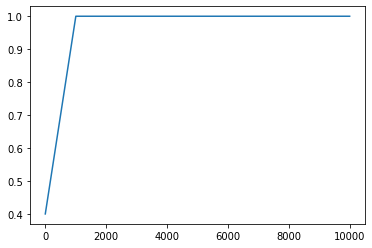

In [5]:
beta_start = .4
beta_frames = 1000
beta_by_frame = lambda frame_idx: min(1., beta_start + frame_idx * (1. - beta_start) / beta_frames)
plt.plot([beta_by_frame(i) for i in range(10000)])
plt.show() 

# Cart Pole Environment

In [6]:
# env_id = 'CartPole-v0'
# env_id = 'CartPole-v1'
import gym_Aircraft
env_id = 'acav-v0'
env = gym.make(env_id) 

/home/hyogun/anaconda3/envs/collision_avoidance/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


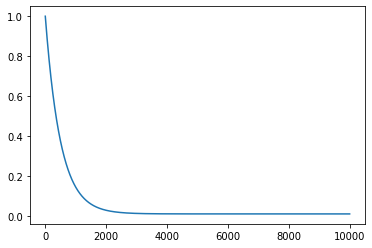

In [7]:
epsilon_start = 1.
epsilon_final = .01
epsilon_decay = 500  # 얼마나 천천히
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)      
plt.plot([epsilon_by_frame(i) for i in range(10000)])
plt.show() 

# Deep Q Network      

In [8]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n),
        )
    
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0)) 
                q_value = self.forward(state)
                action  = q_value.max(1)[1].data[0]  # 제일 궁금한 부분: 왜 이렇게 깔끔한가
        else:
            action = random.randrange(env.action_space.n)
        return action

In [9]:
# 이 분은 진짜로 두 개를 만드셨네: GPU 그렇게 많이 안 쓰니까 별 상관 없긴 할 듯
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model = target_model.cuda()

optimizer = optim.Adam(current_model.parameters())
replay_buffer = NaivePrioritizeBuffer(100000) 

### Synchronize current policy net and target net

In [10]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict()) 

In [11]:
update_target(current_model, target_model)

# Computing Temporal Difference Loss

In [12]:
def compute_td_loss(batch_size, beta):
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)
    
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    weights    = Variable(torch.FloatTensor(weights))
    
    q_values = current_model(state)
    next_q_values = target_model(next_state)
    
    # 얘들 shape 좀 보고 싶다
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)  # if 문 처리를 이렇게 하네
    
    # critetion 없어도 댐
    loss = (q_value - expected_q_value.detach()).pow(2) * weights
    prios = loss + 1e-5
    loss = loss.mean()
    
    optimizer.zero_grad()
    loss.backward()
    # 왜 여기서 업데이트 하는 거지?
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()
    
    return loss

In [13]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(15, 15))
    plt.subplot(211)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(212)
    plt.title('loss')
    plt.plot(losses)
    plt.show() 

# Training

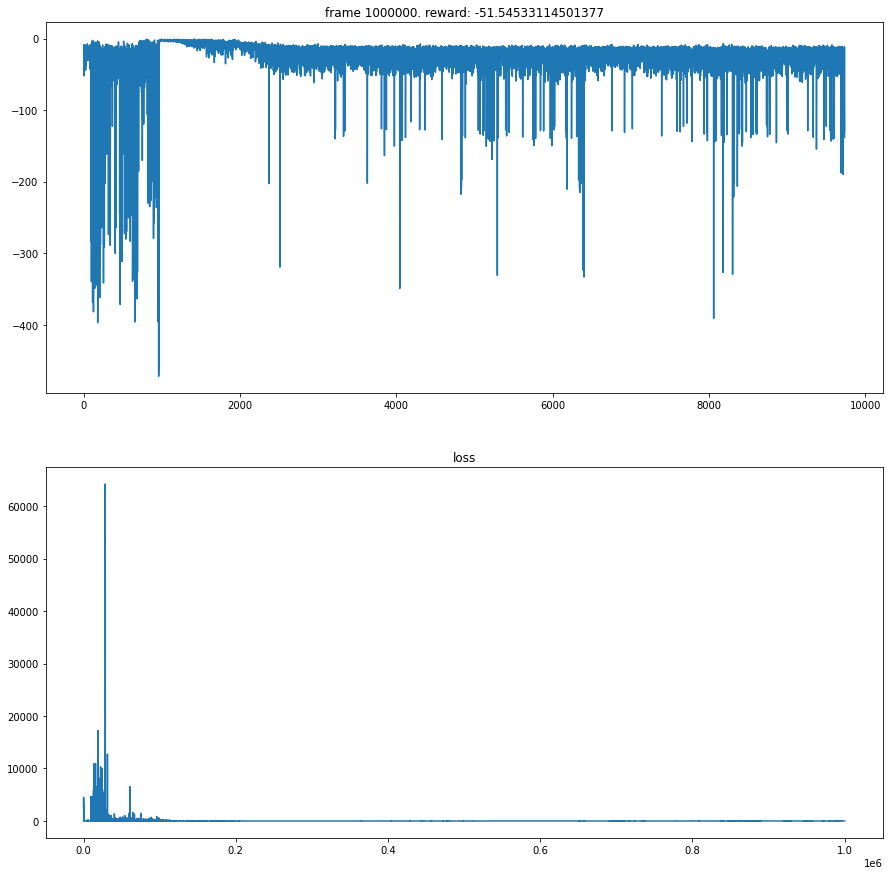

In [14]:
num_frames = 1000000
batch_size = 32
gamma      = 1#0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(int(action))
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        beta = beta_by_frame(frame_idx)
        loss = compute_td_loss(batch_size, beta)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)

# 해볼 것
- 건우는 아직 env 구현이 안된 듯
내 env + Rainbow 해보면 될 거 같은데
\> 안됨
- 궤적 그려보기